<h1>Scraping Historical Weather Data</h1>
<p>As it was challenging to find a free API, this sheet scrapes historical weather data for the toronto area from <a href="www.timeanddate.com" title="A site for time and data and weather">www.timeanddate.com</a>.  It then parses and cleans up the data and saves it into an SQL database for later use.</p>

In [1]:
from bs4 import BeautifulSoup as soup
import requests
import pandas as pd
import numpy as np
import os
from datetime import datetime as dt, timedelta
from dateutil.relativedelta import *
import re
import json
import sqlite3

<h2>Getting the Data</h2>
<p>The following code scrapes the weather data from Jan 1, 2017 to Jan 1, 2020 with the exception of February 21, 2018 which is not available either on the website as well and will need to be added manually</p>

In [2]:
startdate="2017-01-01"
startdate_dt = dt.strptime(startdate,"%Y-%m-%d")
enddate="2020-01-01"
enddate_dt = dt.strptime(enddate,"%Y-%m-%d")
days_to_request = (enddate_dt-startdate_dt).days

weatherdata = pd.DataFrame()
print('starting!')
for i in range(days_to_request):
    day=[]

    url = 'https://www.timeanddate.com/scripts/cityajax.php?n=canada/toronto&mode=historic&hd=%s&month=%s&year=%s&json=1'%(dt.strftime(startdate_dt,"%Y%m%d"),dt.strftime(startdate_dt,"%m"),dt.strftime(startdate_dt,"%Y"))
    headers = {
    'Accept': '*/*', 'Accept-Language': 'en-US,en;q=0.5', 'Accept-Encoding': 'gzip, deflate, br',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.88 Safari/537.36',
    }
    
    try:
        response  = requests.get(url, headers=headers)
        raw_json = eval(response.text.replace(',{c:', '""",{c:').replace('{c:', '"""{c:')[::-1].replace(']', ']"""', 1)[::-1])

        #parse each day's data
        for q,i in enumerate(raw_json):
            json_data = eval(i.replace('{c:', '{"c":').replace('{h:', '{"h":').replace('{s:', '{"s":').replace(',h:', ',"h":').replace('="', '=\'').replace('">', '\'>').replace('" ', '\' '))
            day.append([soup(elem['h'],'lxml').text for elem in json_data['c']])
            if q == 0: #need to fix first element which has time+date
                day[0][0] = re.search(r'(\d{,2}:\d{2} am)',day[0][0])[0]

        #push into DataFrame
        tempDF = pd.DataFrame(day,columns=['time','del','temp','forecast','wind','wind_dir','humidity','pressure','visiblity'])
        #add Date
        tempDF['Date'] = dt.strftime(startdate_dt,"%Y-%m-%d")


        if weatherdata.shape[0]==0:
            weatherdata = tempDF.copy()
        else:
            weatherdata = weatherdata.append(tempDF,ignore_index=True)
    except:
        print('Failed to parse: %s'% dt.strftime(startdate_dt,"%Y%m%d"))
    startdate_dt = startdate_dt +relativedelta(days=+1) 
print('Success!')
weatherdata.head(5)

starting!
Failed to parse: 20180221
Success!


,time,del,temp,forecast,wind,wind_dir,humidity,pressure,visiblity,Date
0,12:00 am,,1 °C,Passing clouds.,35 km\/h,↑,65%,100.79 kPa,24 km,2017-01-01
1,1:00 am,,0 °C,Passing clouds.,35 km\/h,↑,69%,100.95 kPa,24 km,2017-01-01
2,2:00 am,,0 °C,Passing clouds.,33 km\/h,↑,69%,101.07 kPa,24 km,2017-01-01
3,3:00 am,,0 °C,Passing clouds.,28 km\/h,↑,69%,101.27 kPa,24 km,2017-01-01
4,4:00 am,,0 °C,Passing clouds.,26 km\/h,↑,69%,101.41 kPa,24 km,2017-01-01


<h2>Cleaning the Data</h2>
<p>The weather data is currently in string format and will need to be converted to floats/datetime/ints where appropriate.  Additionally, there are some data formats that we don't need and we can go ahead and delete (['del','wind_dir','pressure'] have no bearing on the study.</p>

In [448]:
#convert to wdata so we only have to download once while developing the code
wdata = weatherdata.copy()
#delete unnecessary data
wdata.drop(columns=['del','wind_dir','pressure'],inplace=True)
wdata.head(5)

,time,temp,forecast,wind,humidity,visiblity,Date
0,12:00 am,1 °C,Passing clouds.,35 km\/h,65%,24 km,2017-01-01
1,1:00 am,0 °C,Passing clouds.,35 km\/h,69%,24 km,2017-01-01
2,2:00 am,0 °C,Passing clouds.,33 km\/h,69%,24 km,2017-01-01
3,3:00 am,0 °C,Passing clouds.,28 km\/h,69%,24 km,2017-01-01
4,4:00 am,0 °C,Passing clouds.,26 km\/h,69%,24 km,2017-01-01


In [449]:
#remove degrees C from temp
wdata['temp'] = wdata['temp'].str.extract(r'([-\d]*)').astype(int)
#replace "No wind" with 0 km/h for wind
wdata['wind'] = wdata['wind'].replace({"No wind":"0 km/h"})
#remove degrees km/h from wind
wdata['wind'] = wdata['wind'].str.extract(r'([-\d]*)').astype(int)
#remove degrees % from humidity
wdata['humidity'] = wdata['humidity'].str.extract(r'([\d]*)').astype(int)
#remove km from visibility
wdata['visiblity'] = wdata['visiblity'].str.extract(r'([\d]*)').astype(int)

In [450]:
#time is harder because we'd like to do two things:
#1. Remove the am/pm
#2. Convert to a float of format hr.xx (hours after midnight)

def time_conv(x):
    """
    INPUT:
    x: Time as a string of format XX:XX am/pm
    OUTPUT:
    t: Time as a float of hours past midnight
    """
    #determine am/pm (need to sort out 24 hr clock)
    if x[-2:] == 'am':
        hr = float(re.search(r'(\d{,2})',x)[1])
        if int(hr) == 12:
            hr = 0.
        mn = float(re.search(r'\d{,2}:(\d{,2})',x)[1])/60
    else:
        hr = float(re.search(r'(\d{,2})',x)[1]) + 12
        if int(hr) == 24:
            hr = 12.
        mn = float(re.search(r'\d{,2}:(\d{,2})',x)[1])/60
        
    return np.round(hr+mn,3)

wdata['time'] = wdata['time'].apply(lambda t:time_conv(t))

<p>We can now look at the weather types for a breakdown of their distributions</p>

In [451]:
wdata.describe()

,time,temp,wind,humidity,visiblity
count,29827.000000,29827.000000,29827.000000,29827.000000,29827.000000
mean,11.539101,8.724411,17.048547,70.927079,20.758809
std,6.873372,10.945680,9.498619,16.518379,6.540746
min,0.000000,-23.000000,0.000000,14.000000,0.000000
25%,6.000000,0.000000,9.000000,60.000000,24.000000
50%,11.617000,8.000000,15.000000,72.000000,24.000000
75%,17.083000,18.000000,22.000000,83.000000,24.000000
max,23.917000,35.000000,87.000000,100.000000,97.000000


Now load in the missed data

In [452]:
missing_data = pd.read_csv('20180221.csv')
missing_data.columns = wdata.columns
missing_data.head()

,time,temp,forecast,wind,humidity,visiblity,Date
0,0.00,14,Mostly Cloudy,13,88,20,2018-02-21
1,0.25,14,Mostly Cloudy,17,82,20,2018-02-21
2,2.00,13,Mostly Cloudy,9,82,20,2018-02-21
3,3.00,13,Mostly Cloudy,9,82,20,2018-02-21
4,4.00,12,Mostly Cloudy,0,88,20,2018-02-21


In [453]:
wdata = wdata.append(missing_data, ignore_index=True)

<p>The solar data that we have is reported every quarter hour, but the weather data is every hour + some additional reporting, therefore we need to create a datetime index and then resample on the hour (we'll do the same with the solar data)</p>

In [465]:
#first check if there are any duplicates
print('Three are %d duplicates'%wdata[['Date','time']].duplicated().sum())
#drop the duplicates
print(wdata[wdata[['Date','time']].duplicated()])
wdata = wdata.drop(labels=wdata[wdata[['Date','time']].duplicated()].index,axis=0)

Three are 3 duplicates
       time  temp                       forecast  wind  humidity  visiblity  \
8424    1.0     6  Thunderstorms. Mostly cloudy.    11        93         10   
18126   1.0     1                Passing clouds.     9        81         24   
28173   1.0     1                Passing clouds.    19        93         24   

             Date  
8424   2017-11-05  
18126  2018-11-04  
28173  2019-11-03  


In [466]:
#make datetime index (will now be unique)
wdata['date_time'] = pd.to_datetime(wdata['Date']+' '+wdata['time'].apply(lambda t:int(t)).astype(str)+':'+wdata['time'].apply(lambda t: int((t-int(t))*60)).astype(str), format='%Y-%m-%d %H:%M', errors='ignore')
#sort based on the date_time so the missing month is in the right place
wdata = wdata.sort_values('date_time')
wdata = wdata.set_index('date_time')
wdata = wdata[['Date','time', 'temp', 'wind', 'humidity', 'visiblity', 'forecast']] #rejig data
print('The current size is %s'% wdata.shape[0])

The current size is 29860


In [468]:
#now resample based on the hour
wdatars = wdata.resample('H').pad()
print('The current size is %s'% wdatars.shape[0])

The current size is 26280


<h1>Create a Database</h1>

<p>We're now ready to save the database for future work.  We'll do this using sqlite, creating a single table for the dataset and another for the dates (to have auto-extracted dates and for explainatory purposes.
</p>

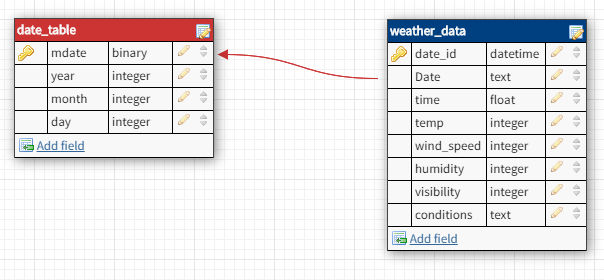

In [579]:
DB = "toronto_weather.db"

#SQL Handle functions
def run_query(q):
    with sqlite3.connect(DB) as conn:
        x = pd.read_sql(q,conn)
    return x
   
#send command
def run_command(c):
    with sqlite3.connect(DB) as conn:
        conn.isolation_level = None
        return conn.execute(c)
    
#show tables
def show_tables():
    r = """
    Select name,type
    FROM sqlite_master
    WHERE type in ("table","view");
        """
    return run_query(r)

In [623]:
#create table
tables = {'wdata':wdatars,'weather_data':1,'date_table':1}
with sqlite3.connect(DB) as conn:
    for name,data in tables.items():
        run_command("DROP TABLE IF EXISTS {}".format(name)) #clear DB of existing tables
        if isinstance(data,pd.DataFrame):
            data.to_sql(name,conn,index=True)
show_tables()

,name,type
0,wdata,table


In [624]:
#show_tables()
run_query("PRAGMA table_info(wdata);")

,cid,name,type,notnull,dflt_value,pk
0,0,date_time,TIMESTAMP,0,None,0
1,1,Date,TEXT,0,None,0
2,2,time,REAL,0,None,0
3,3,temp,INTEGER,0,None,0
4,4,wind,INTEGER,0,None,0
5,5,humidity,INTEGER,0,None,0
6,6,visiblity,INTEGER,0,None,0
7,7,forecast,TEXT,0,None,0


In [625]:
#make a new data/time table for analysing data
c1 = """
CREATE TABLE IF NOT EXISTS date_table (
    mdate TEXT PRIMARY KEY,
    year INTEGER,
    month INTEGER,
    day INTEGER
);
"""

c2 = """
INSERT OR IGNORE INTO date_table
SELECT 
Date,
CAST(SUBSTR(Date,0,5) AS INT),
CAST(SUBSTR(Date,6,2) AS INT),
CAST(SUBSTR(Date,9,2) AS INT)
FROM wdata
"""

q = """
SELECT * FROM date_table
LIMIT 5;
"""

run_command(c1)
run_command(c2)
run_query(q)

,mdate,year,month,day
0,2017-01-01,2017,1,1
1,2017-01-02,2017,1,2
2,2017-01-03,2017,1,3
3,2017-01-04,2017,1,4
4,2017-01-05,2017,1,5


In [626]:
#make a new table with the appropriate keys
c1 = """
    CREATE TABLE IF NOT EXISTS weather_data (
    date_id TIMESTAMP PRIMARY KEY,
    date TEXT,
    time REAL,
    temp INTEGER,
    wind_speed INTEGER,
    humidity INTEGER,
    visability INTEGER,
    conditions TEXT,
    FOREIGN KEY (date) REFERENCES date_table(mdate)
);
"""

c2 = """
INSERT OR IGNORE INTO weather_data
SELECT *
FROM wdata;
"""

q = """
SELECT * FROM weather_data
LIMIT 5;
"""

run_command(c1)
run_command(c2)
run_query(q)

,date_id,date,time,temp,wind_speed,humidity,visability,conditions
0,2017-01-01 00:00:00,2017-01-01,0.0,1,35,65,24,Passing clouds.
1,2017-01-01 01:00:00,2017-01-01,1.0,0,35,69,24,Passing clouds.
2,2017-01-01 02:00:00,2017-01-01,2.0,0,33,69,24,Passing clouds.
3,2017-01-01 03:00:00,2017-01-01,3.0,0,28,69,24,Passing clouds.
4,2017-01-01 04:00:00,2017-01-01,4.0,0,26,69,24,Passing clouds.


In [627]:
run_command("DROP TABLE wdata")